<a href="https://colab.research.google.com/github/hosseinrezaie0/tweet-sentiment-analysis/blob/main/Logistic_Regression.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import re
import string
import matplotlib.pyplot as plt

In [66]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [68]:
# Split the data - 80% for traiing and 20% for testing
train_pos, test_pos, train_neg, test_neg = positive_tweets[:4000], positive_tweets[4000:], negative_tweets[:4000], negative_tweets[4000:]

x_train = train_pos + train_neg
x_test = test_pos + test_neg

In [69]:
x_train[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

In [70]:
# Add label to data set
y_train = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
y_test = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [71]:
y_train.shape

(8000, 1)

In [72]:
y_train[0]

array([1.])

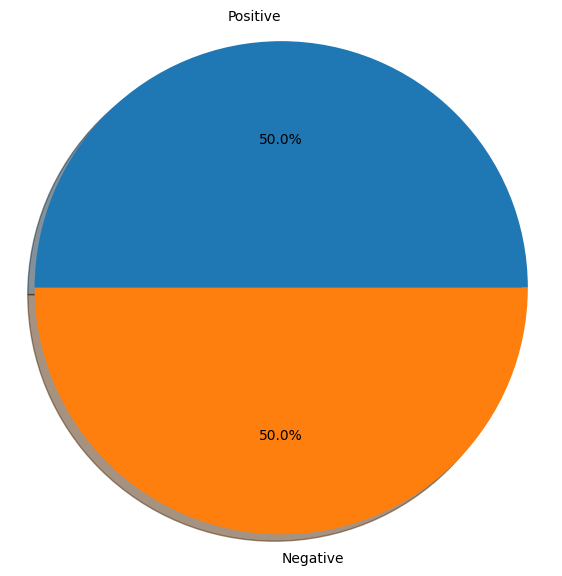

In [73]:
fig = plt.figure(figsize=(7, 7))
labels = 'Positive', 'Negative'
sizes = [len(train_pos),len(train_neg)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%' ,startangle=0, shadow=True)
plt.axis('equal')
plt.show()

In [77]:
class TweetProcessor:
  def __init__(self, tweets, labels):
    self.tweets = tweets
    self.stemmer = PorterStemmer()
    self.stopwords_english = stopwords.words('english')
    self.tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    self.freqs = {}
    self.vocab = []
    self.labels = labels
    # self.processed_tweets = []

  '''
  for processing the tweets we follow the following steps:
    1. Remove special characters using regex
    2. Tokenize the tweets
    3. Remove stopwords
    4. Stem the tokens
  '''
  def process_tweet(self, tweet):
    # Lowercase the tweet
    tweet = tweet.lower()

    # Remove hyperlinks
    tweet = re.sub(r'https?://\S+', '', tweet)

    # Remove hashtags
    tweet = re.sub(r'#[^\s\n\r]+', '', tweet)

    # Remove mentions
    tweet = re.sub(r'@[^\s\n\r]+', '', tweet)

    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)

    # Tokenize the tweet
    tweet_tokens = self.tokenizer.tokenize(tweet)

    # Remove stopwords
    tweet_tokens = [token for token in tweet_tokens if not token in self.stopwords_english]

    # Remove punctuation
    tweet_tokens = [token for token in tweet_tokens if not token in string.punctuation]

    # Stem the tokens
    tweet_tokens = [self.stemmer.stem(token) for token in tweet_tokens]

    return tweet_tokens

  def build_vocab(self):
    for tweet in self.tweets:
      for word in self.process_tweet(tweet):
        if word not in self.vocab:
          self.vocab.append(word)

  def build_freqs(self):
    for y, tweet in zip(self.labels, self.tweets):
      for word in self.process_tweet(tweet):
          # Extract the scalar value from the numpy array
          pair = (word, int(y[0]))
          if pair in self.freqs:
            self.freqs[pair] += 1
          else:
            self.freqs[pair] = 1

In [86]:
class FeatureExtractor:
  def __init__(self, freqs, tweets, labels):
    self.freqs = freqs
    self.tweets = tweets
    self.features = np.zeros((len(tweets), 3))
    self.labels = labels
    self.tp = TweetProcessor(self.tweets, self.labels)

  def extract_features(self):
    for i, tweet in enumerate(self.tweets):
      x = np.zeros(3)
      x[0] = 1 # bias
      for word in self.tp.process_tweet(tweet):
        if (word, 1) in self.freqs:
          x[1] += self.freqs[(word, 1)]
        if (word, 0) in self.freqs:
          x[2] += self.freqs[(word, 0)]
      self.features[i, :] = x

In [79]:
tp = TweetProcessor(x_train, y_train)
tp.build_vocab()
tp.build_freqs()

In [80]:
vocab = tp.vocab
freqs = tp.freqs

In [81]:
vocab[:10]

['top', 'engag', 'member', 'commun', 'week', ':)', 'hey', 'jame', 'odd', ':/']

In [82]:
len(vocab)

7944

In [83]:
dict(list(freqs.items())[:10])

{('top', 1): 30,
 ('engag', 1): 7,
 ('member', 1): 14,
 ('commun', 1): 26,
 ('week', 1): 74,
 (':)', 1): 2960,
 ('hey', 1): 60,
 ('jame', 1): 7,
 ('odd', 1): 2,
 (':/', 1): 5}

In [84]:
len(freqs)

10059

In [90]:
fe = FeatureExtractor(freqs, x_train, y_train)
fe.extract_features()

In [91]:
features = fe.features

In [92]:
features

array([[1.000e+00, 3.111e+03, 6.300e+01],
       [1.000e+00, 3.704e+03, 4.440e+02],
       [1.000e+00, 3.119e+03, 1.160e+02],
       ...,
       [1.000e+00, 1.440e+02, 7.920e+02],
       [1.000e+00, 2.070e+02, 3.901e+03],
       [1.000e+00, 1.870e+02, 3.983e+03]])